In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import silhouette_score






In [2]:
df = pd.read_csv('Sample-Superstore.csv', encoding='windows-1254')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [38]:
df.shape

(9994, 21)

In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df.dtypes


Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date                object
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [81]:
df[['Order Date']].head()

,Order Date
0,2016-11-08
1,2016-11-08
2,2016-06-12
3,2015-10-11
4,2015-10-11


In [5]:
# Aggregate by Customer ID to get the number of orders
repeat_df = df.groupby('Customer ID').agg({
    'Order ID': 'nunique',          # Number of unique orders (frequency of purchase)
    'Sales': 'sum',                 # Total amount spent
    'Quantity': 'sum',              # Total quantity of items purchased
    'Discount': 'mean',             # Average discount received
    'Profit': 'sum',                # Total profit generated
    'Order Date': 'max',            # Most recent purchase date (for recency)
    'Ship Mode': lambda x: x.mode()[0],  # Most frequent ship mode
    'Segment': lambda x: x.mode()[0],    # Most frequent segment
    'Region': lambda x: x.mode()[0]      # Most frequent region
})

# Rename columns for clarity
repeat_df.rename(columns={'Order ID': 'repeat_purchase_count'}, inplace=True)
repeat_df['repeat_purchase_count'] = repeat_df['repeat_purchase_count'] - 1  # Adjust for repeat count


In [6]:
from datetime import datetime

# Assume today's date for recency calculation
today_date = datetime.today()

# Calculate recency in days
repeat_df['Recency'] = (today_date - repeat_df['Order Date']).dt.days


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
repeat_df['Ship Mode'] = LabelEncoder().fit_transform(repeat_df['Ship Mode'])
repeat_df['Segment'] = LabelEncoder().fit_transform(repeat_df['Segment'])
repeat_df['Region'] = LabelEncoder().fit_transform(repeat_df['Region'])

# Define features and target variable
X = repeat_df[['Sales', 'Discount', 'Profit', 'Segment', 'Recency']]
y = repeat_df['repeat_purchase_count']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
mse = root_mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 2.4298481463716985


In [8]:
y_pred = model.predict(X_test)


C:\Users\media\AppData\Local\Temp\ipykernel_15356\3403318918.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', lw=2, label="Ideal Fit")


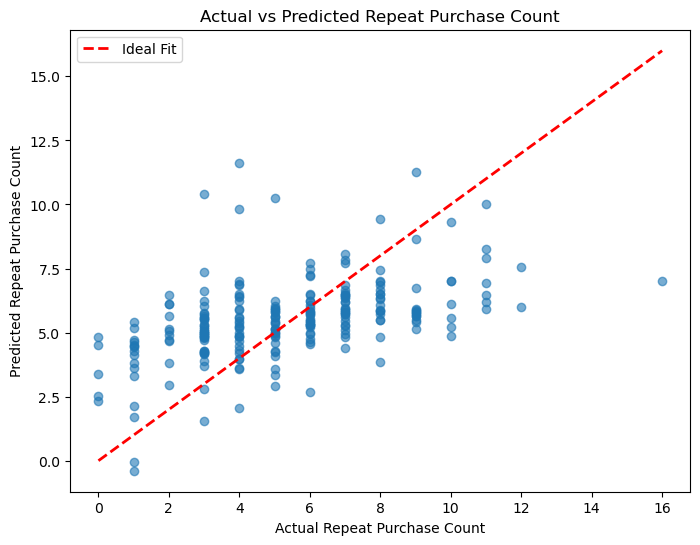

In [9]:
# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', lw=2, label="Ideal Fit")
plt.xlabel("Actual Repeat Purchase Count")
plt.ylabel("Predicted Repeat Purchase Count")
plt.title("Actual vs Predicted Repeat Purchase Count")
plt.legend()
plt.show()


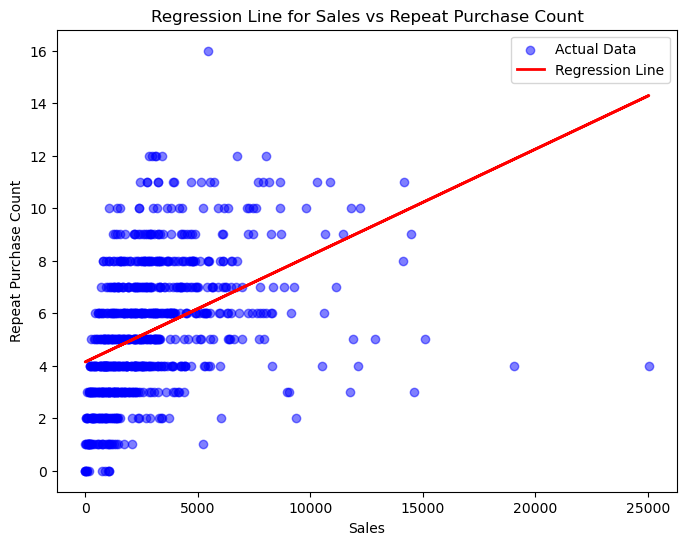

In [12]:
# For illustration, fit a model using only the 'Sales' feature
X_single_feature = repeat_df[['Sales']].values
y = repeat_df['repeat_purchase_count']

# Train a simple linear regression model
from sklearn.linear_model import LinearRegression
simple_model = LinearRegression()
simple_model.fit(X_single_feature, y)

# Predictions for plotting
y_single_pred = simple_model.predict(X_single_feature)

# Plot the regression line with data points
plt.figure(figsize=(8, 6))
plt.scatter(repeat_df['Sales'], y, color='blue', alpha=0.5, label="Actual Data")
plt.plot(repeat_df['Sales'], y_single_pred, color='red', linewidth=2, label="Regression Line")
plt.xlabel("Sales")
plt.ylabel("Repeat Purchase Count")
plt.title("Regression Line for Sales vs Repeat Purchase Count")
plt.legend()
plt.show()


In [13]:

# Load your data
# df = pd.read_csv("your_data.csv")

# Ensure Order Date is in datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Extract quarter and year from Order Date
df['Quarter'] = df['Order Date'].dt.to_period('Q')

# Group by Segment and Quarter to aggregate Sales and Profit Margin
df_segmented = df.groupby(['Segment', 'Quarter']).agg({
    'Sales': 'sum',
    'Profit': 'mean'  # Assuming Profit column represents the average profit margin
}).reset_index()


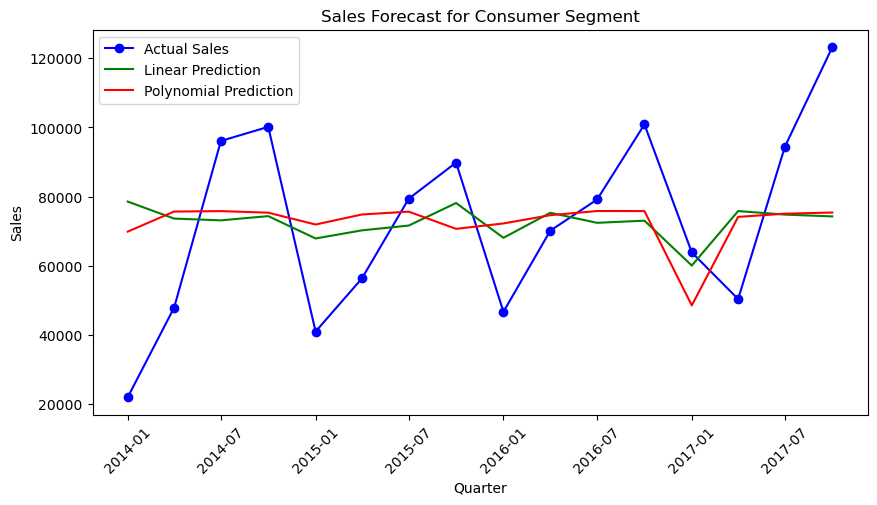

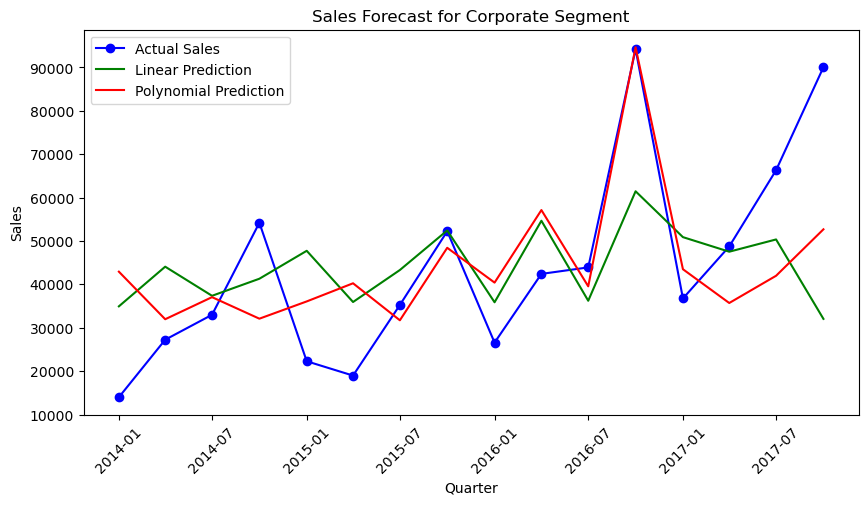

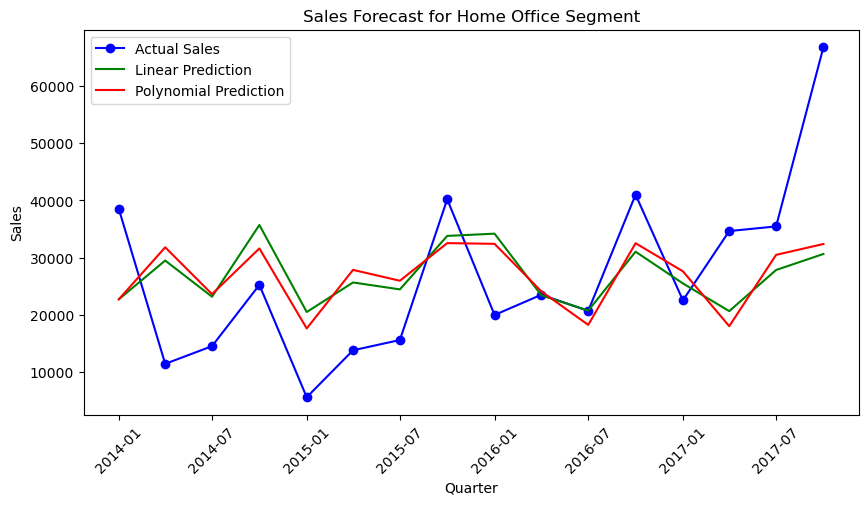

In [15]:
import pandas as pd

# Sample data setup (assuming your DataFrame is called df)
# Ensure Order Date is in datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Extract quarter and year from Order Date as Period (for grouping)
df['Quarter'] = df['Order Date'].dt.to_period('Q')

# Group by Segment and Quarter to aggregate Sales and Profit Margin
df_segmented = df.groupby(['Segment', 'Quarter']).agg({
    'Sales': 'sum',
    'Profit': 'mean'  # Assuming Profit column represents the average profit margin
}).reset_index()

# Convert 'Quarter' period to timestamp format for plotting
df_segmented['Quarter'] = df_segmented['Quarter'].dt.start_time  # Converts to the first day of each quarter

# Function to fit and plot models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt

def fit_and_plot(segment_data, segment_name):
    # Linear Regression
    X = segment_data[['Average Profit Margin']]  # predictor
    y = segment_data['Sales']  # target

    # Fit linear model
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    
    # Polynomial Regression (degree 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(segment_data['Quarter'], y, label="Actual Sales", color="blue", marker="o")
    plt.plot(segment_data['Quarter'], y_pred_linear, label="Linear Prediction", color="green")
    plt.plot(segment_data['Quarter'], y_pred_poly, label="Polynomial Prediction", color="red")
    plt.title(f"Sales Forecast for {segment_name} Segment")
    plt.xlabel("Quarter")
    plt.ylabel("Sales")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Apply function for each segment
for segment in df_segmented['Segment'].unique():
    segment_data = df_segmented[df_segmented['Segment'] == segment]
    segment_data = segment_data.rename(columns={'Profit': 'Average Profit Margin'})
    fit_and_plot(segment_data, segment)


In [83]:
df.duplicated(subset=['Order ID', 'Customer ID','Product ID']).sum()

np.int64(8)

In [84]:
df.duplicated(subset=['Order ID']).sum()

np.int64(4985)

Clustering in Monetary, Fequency and Recency

In [10]:
df_monetary = df.groupby('Customer ID', as_index=False)['Sales'].sum()
df_monetary.rename(columns={'Sales': 'Amount'}, inplace=True)
df_monetary.head()

,Customer ID,Amount
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [11]:
df_frequency = df.groupby('Customer ID', as_index=False)['Order ID'].nunique()
df_frequency.rename(columns={'Order ID': 'Frequency'}, inplace=True)
df_frequency.head()


,Customer ID,Frequency
0,AA-10315,5
1,AA-10375,9
2,AA-10480,4
3,AA-10645,6
4,AB-10015,3


In [12]:
today = datetime.today()
print(today)


2024-11-06 11:50:26.978408


In [13]:
df_recency = df.groupby('Customer ID', as_index=False)['Order Date'].max()
df_recency.rename(columns={'Order Date': 'LastOrderDate'}, inplace=True)
df_recency.head()


,Customer ID,LastOrderDate
0,AA-10315,2017-06-29
1,AA-10375,2017-12-11
2,AA-10480,2017-04-15
3,AA-10645,2017-11-05
4,AB-10015,2016-11-10


In [14]:
df_recency['Recency'] = (today - df_recency['LastOrderDate']).dt.days


In [90]:
#time_result = (today - df_recency['LastOrderDate']).dt.days
#print(time_result)
               

In [15]:
df_recency.drop(columns=['LastOrderDate'], inplace=True)


In [16]:
df_recency.head()

,Customer ID,Recency
0,AA-10315,2687
1,AA-10375,2522
2,AA-10480,2762
3,AA-10645,2558
4,AB-10015,2918


In [93]:
df_recency.columns

Index(['Customer ID', 'Recency'], dtype='object')

Merging all three created dataframes on Customer ID column

In [17]:
# First, merge df_monetary and df_frequency on 'Customer ID'
merged_df = pd.merge(df_monetary, df_frequency, on='Customer ID')

# Then, merge the resulting DataFrame with df_recency on 'Customer ID'
merged_df = pd.merge(merged_df, df_recency, on='Customer ID')
merged_df

,Customer ID,Amount,Frequency,Recency
0,AA-10315,5563.560,5,2687
1,AA-10375,1056.390,9,2522
2,AA-10480,1790.512,4,2762
3,AA-10645,5086.935,6,2558
4,AB-10015,886.156,3,2918
...,...,...,...,...
788,XP-21865,2374.658,11,2546
789,YC-21895,5454.350,5,2507
790,YS-21880,6720.444,8,2512
791,ZC-21910,8025.707,13,2557


detecting outliers via boxplots

<Axes: xlabel='Frequency', ylabel='Amount'>

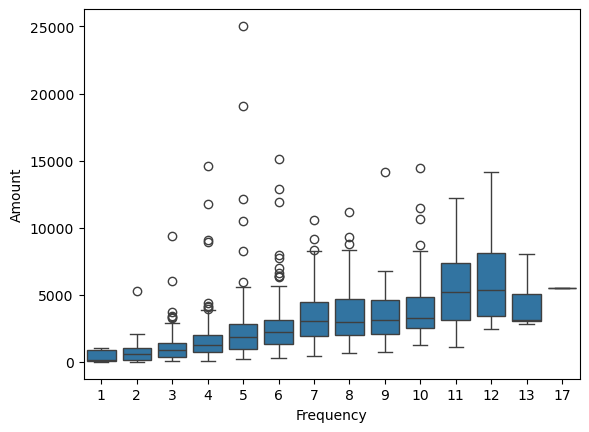

In [18]:
sns.boxplot(data=merged_df, x= 'Frequency', y='Amount')

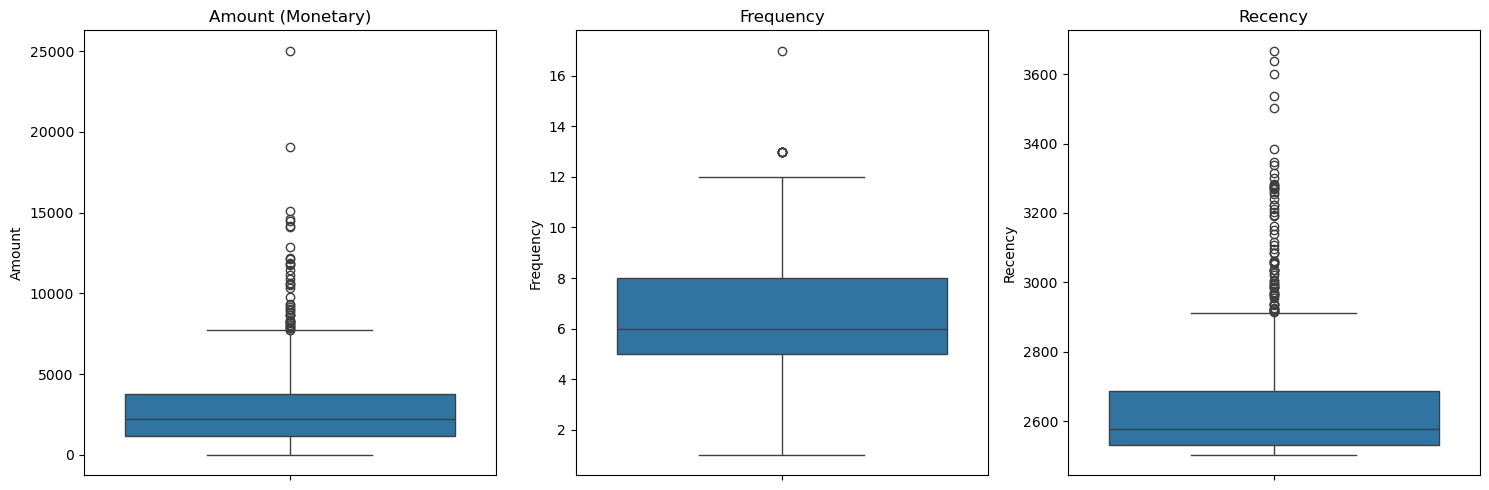

In [19]:

# Load data (replace 'merged_df.csv' with the actual file path if needed)
# merged_df = pd.read_csv('merged_df.csv') 

# Set up the plotting style
sns.set_style=("whitegrid")

# Create a figure with 3 subplots (one for each parameter)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Boxplot for 'Amount'
sns.boxplot(y=merged_df['Amount'], ax=axes[0])
axes[0].set_title('Amount (Monetary)')

# Boxplot for 'Frequency'
sns.boxplot(y=merged_df['Frequency'], ax=axes[1])
axes[1].set_title('Frequency')

# Boxplot for 'Recency'
sns.boxplot(y=merged_df['Recency'], ax=axes[2])
axes[2].set_title('Recency')

# Display the plot
plt.tight_layout()
plt.show()


In [20]:

# Function to remove outliers based on IQR
def remove_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for the column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate the IQR
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame to only include values within the bounds
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for 'Amount', 'Frequency', and 'Recency'
cleaned_df = remove_outliers_iqr(merged_df, 'Amount')
cleaned_df = remove_outliers_iqr(cleaned_df, 'Frequency')
cleaned_df = remove_outliers_iqr(cleaned_df, 'Recency')

# Display the resulting DataFrame without outliers
cleaned_df.head()


,Customer ID,Amount,Frequency,Recency
0,AA-10315,5563.560,5,2687
1,AA-10375,1056.390,9,2522
2,AA-10480,1790.512,4,2762
3,AA-10645,5086.935,6,2558
7,AB-10150,966.710,5,2544


In [21]:
remove_outliers_iqr(cleaned_df, 'Frequency')

,Customer ID,Amount,Frequency,Recency
0,AA-10315,5563.560,5,2687
1,AA-10375,1056.390,9,2522
2,AA-10480,1790.512,4,2762
3,AA-10645,5086.935,6,2558
7,AB-10150,966.710,5,2544
...,...,...,...,...
787,WB-21850,6160.102,11,2523
788,XP-21865,2374.658,11,2546
789,YC-21895,5454.350,5,2507
790,YS-21880,6720.444,8,2512


In [22]:
remove_outliers_iqr(cleaned_df, 'Recency')

,Customer ID,Amount,Frequency,Recency
0,AA-10315,5563.560,5,2687
1,AA-10375,1056.390,9,2522
2,AA-10480,1790.512,4,2762
3,AA-10645,5086.935,6,2558
7,AB-10150,966.710,5,2544
...,...,...,...,...
787,WB-21850,6160.102,11,2523
788,XP-21865,2374.658,11,2546
789,YC-21895,5454.350,5,2507
790,YS-21880,6720.444,8,2512


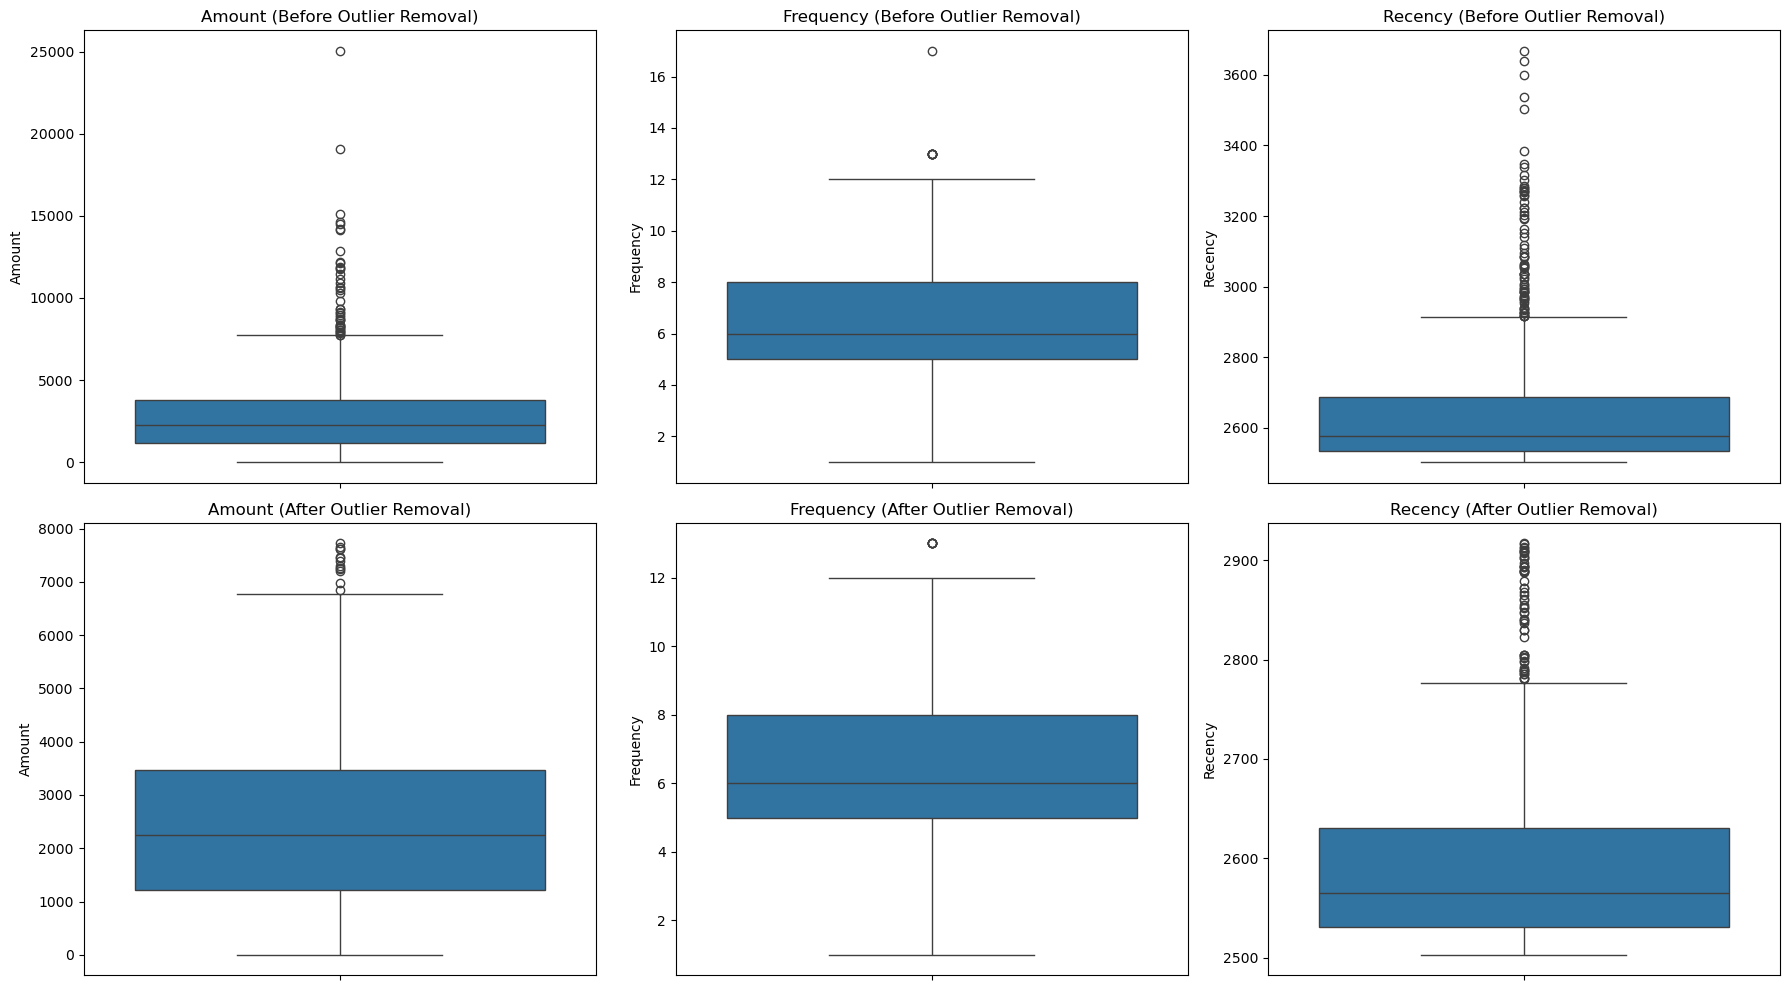

In [25]:

sns.set_style=("whitegrid")

# Create a figure with 2 rows and 3 columns (one row for original, one for cleaned data)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Plot for 'Amount' before and after outlier removal
sns.boxplot(y=merged_df['Amount'], ax=axes[0, 0])
axes[0, 0].set_title('Amount (Before Outlier Removal)')
sns.boxplot(y=cleaned_df['Amount'], ax=axes[1, 0])
axes[1, 0].set_title('Amount (After Outlier Removal)')

# Plot for 'Frequency' before and after outlier removal
sns.boxplot(y=merged_df['Frequency'], ax=axes[0, 1])
axes[0, 1].set_title('Frequency (Before Outlier Removal)')
sns.boxplot(y=cleaned_df['Frequency'], ax=axes[1, 1])
axes[1, 1].set_title('Frequency (After Outlier Removal)')

# Plot for 'Recency' before and after outlier removal
sns.boxplot(y=merged_df['Recency'], ax=axes[0, 2])
axes[0, 2].set_title('Recency (Before Outlier Removal)')
sns.boxplot(y=cleaned_df['Recency'], ax=axes[1, 2])
axes[1, 2].set_title('Recency (After Outlier Removal)')

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [26]:
# assign the label
merged_df['Cluster_Id'] = kmeans.labels_
merged_df.head()

NameError: name 'kmeans' is not defined

<Axes: xlabel='Cluster_Id', ylabel='Amount'>

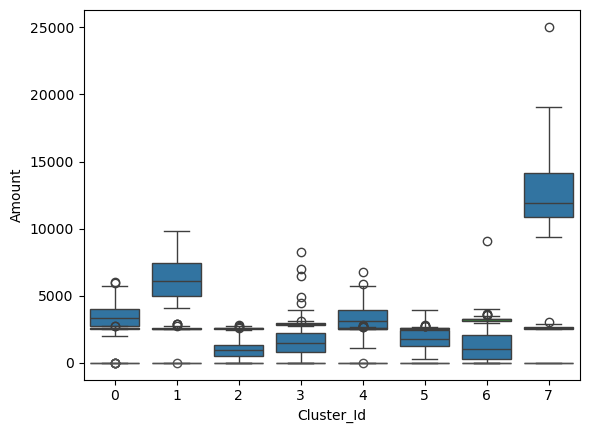

In [118]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=merged_df)

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=merged_df)

# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=merged_df)

In [29]:
# Rescaling the attributes
rfm_df = merged_df[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,1.015112,-0.516429,0.199889
1,-0.700590,1.052644,-0.686762
2,-0.421139,-0.908697,0.602912
3,0.833680,-0.124161,-0.493311
4,-0.765391,-1.300965,1.441199


Building the model

In [30]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [31]:
# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(np.int32(0), 294), (np.int32(1), 333), (np.int32(2), 96), (np.int32(3), 70)]

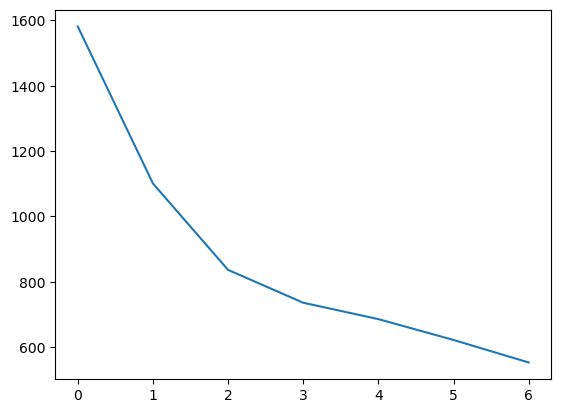

In [32]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

In [33]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3278536772323133
For n_clusters=3, the silhouette score is 0.3655945901531618
For n_clusters=4, the silhouette score is 0.3538835014109635
For n_clusters=5, the silhouette score is 0.29311514742946465
For n_clusters=6, the silhouette score is 0.2778712399056056
For n_clusters=7, the silhouette score is 0.2862929881932278
For n_clusters=8, the silhouette score is 0.29328005827315823


            Recency  Frequency       Amount
Cluster                                    
0         88.823129   5.512472  1843.926364
1        531.423423   3.774775  1636.864907
2         79.037344   8.958506  5403.889333


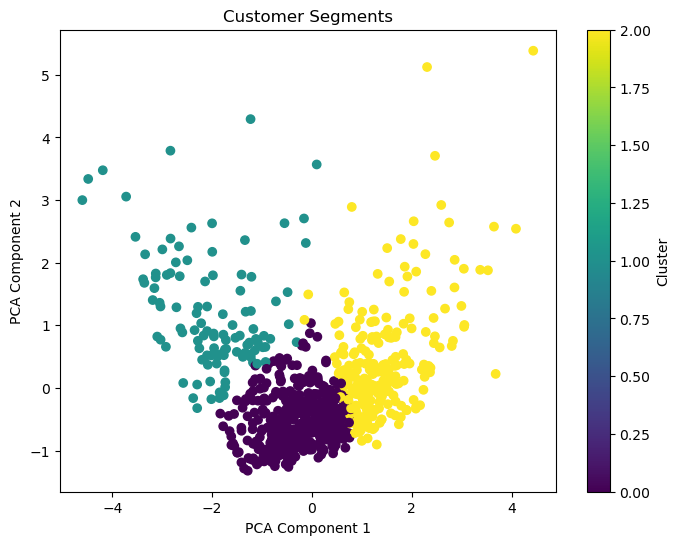

In [37]:
from datetime import datetime, timedelta


# 2. Create rfm_customer features
analysis_date = df['Order Date'].max() + timedelta(days=1)

# Calculate Recency
recency = df.groupby('Customer ID')['Order Date'].max().reset_index()
recency['Recency'] = (analysis_date - recency['Order Date']).dt.days

# **Drop 'Order Date' column**
recency = recency[['Customer ID', 'Recency']]

# Calculate Frequency
frequency = df.groupby('Customer ID')['Order ID'].nunique().reset_index()
frequency.rename(columns={'Order ID': 'Frequency'}, inplace=True)

# Calculate Monetary Value
monetary = df.groupby('Customer ID')['Sales'].sum().reset_index()
monetary.rename(columns={'Sales': 'Amount'}, inplace=True)

# Merge rfm_customer features
rfm_customer = recency.merge(frequency, on='Customer ID').merge(monetary, on='Customer ID')




# 4. Feature Scaling
rfm_customer.set_index('Customer ID', inplace=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm_customer)

# 5. Determine optimal K (e.g., using Elbow Method)

# 6. Apply K-Means clustering
optimal_k = 3 # Replace with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)
rfm_customer['Cluster'] = kmeans.labels_

# 7. Analyze clusters
print(rfm_customer.groupby('Cluster').mean())

# 8. Visualize clusters using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
plt.figure(figsize=(8,6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=rfm_customer['Cluster'], cmap='viridis')
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()